In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [9]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [10]:
df.shape

(319795, 18)

In [11]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  str    
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  str    
 3   AlcoholDrinking   319795 non-null  str    
 4   Stroke            319795 non-null  str    
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  str    
 8   Sex               319795 non-null  str    
 9   AgeCategory       319795 non-null  str    
 10  Race              319795 non-null  str    
 11  Diabetic          319795 non-null  str    
 12  PhysicalActivity  319795 non-null  str    
 13  GenHealth         319795 non-null  str    
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  str    
 16  KidneyDisease     319795 non-nu

In [12]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [13]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

No null values

In [14]:
df.duplicated().sum()

np.int64(18078)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.shape

(301717, 18)

Dropped 18k Duplicated rows

<Axes: xlabel='HeartDisease', ylabel='count'>

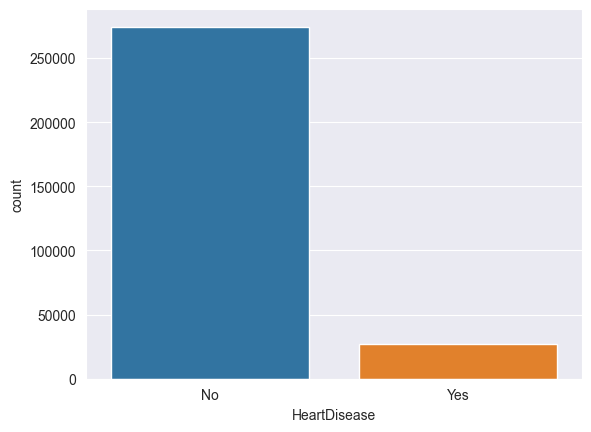

In [17]:
sns.countplot(x = 'HeartDisease', data= df, hue='HeartDisease')

In [18]:
df['HeartDisease'].value_counts(normalize=True) * 100

HeartDisease
No     90.964712
Yes     9.035288
Name: proportion, dtype: float64

# only 9% positive class data we have, the data is highly imbalanced, will need to use stratified k fold CV

In [19]:
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(exclude='number').columns

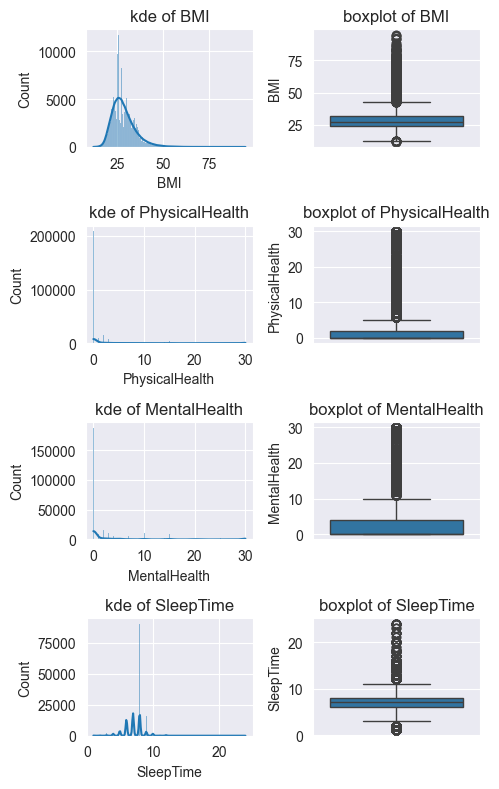

In [20]:
# Analysis on numerical features (histogram with kde and boxplot)
fig, ax = plt.subplots(len(numerical_features), 2, figsize=(5, 2 * len(numerical_features)))

for i in range(len(numerical_features)):
  sns.histplot(df[numerical_features[i]], kde = True, ax=ax[i,0])
  ax[i,0].set_title(f'kde of {numerical_features[i]}')
  sns.boxplot(df[numerical_features[i]], ax=ax[i,1])
  ax[i,1].set_title(f'boxplot of {numerical_features[i]}')


plt.tight_layout()
plt.show()



All the numerical columns have outliers
, Notice that there is a outlier in columns SleepTime with sleep of 24 hrs and the one with 0 hrs

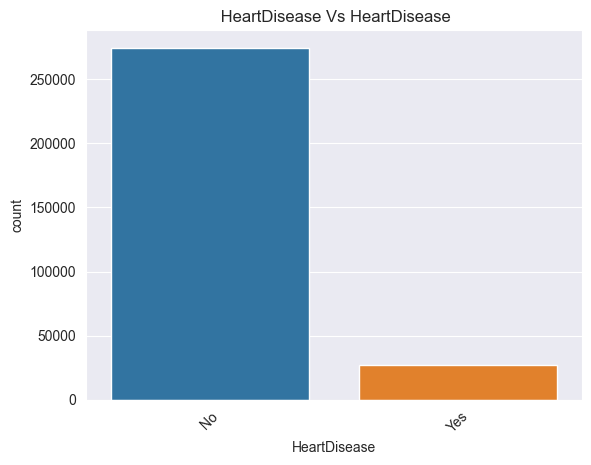

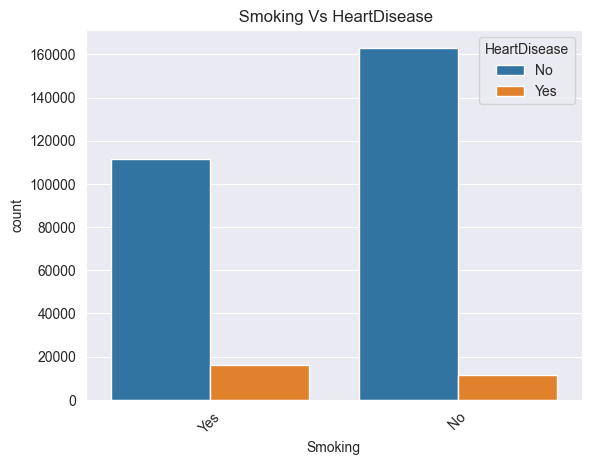

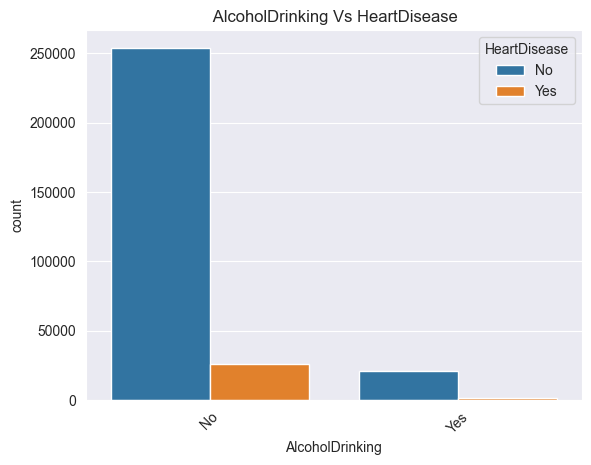

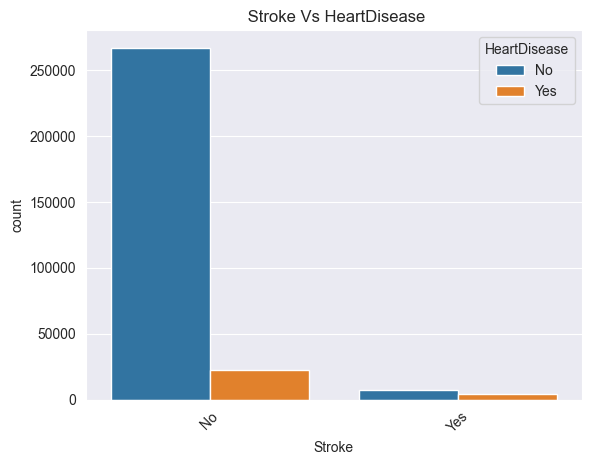

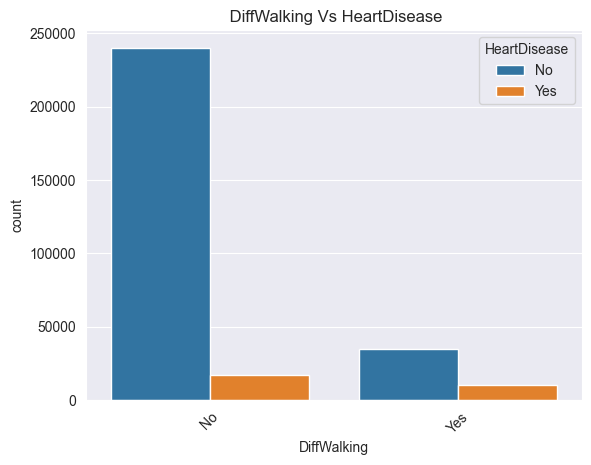

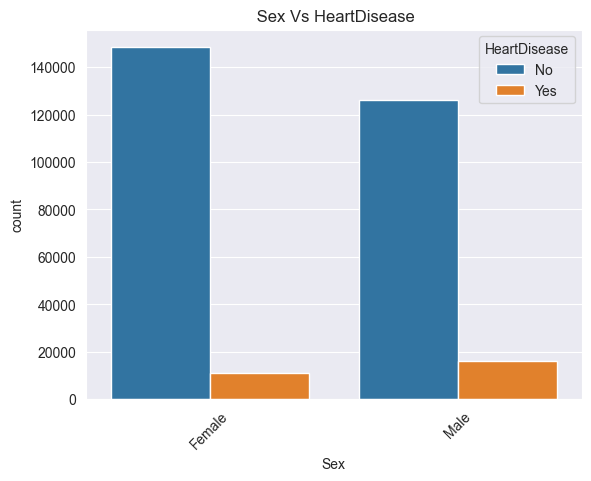

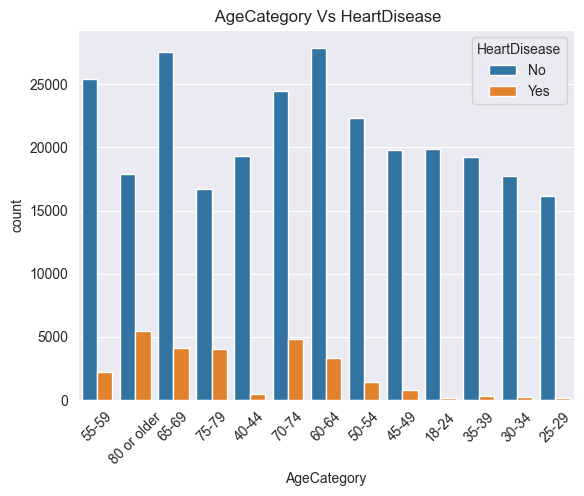

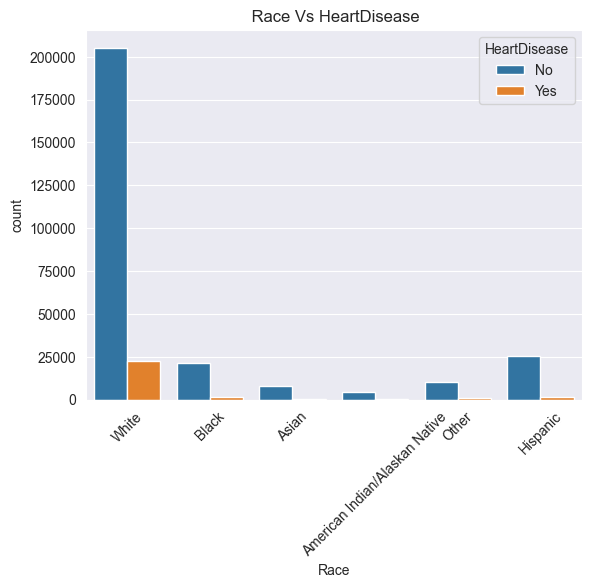

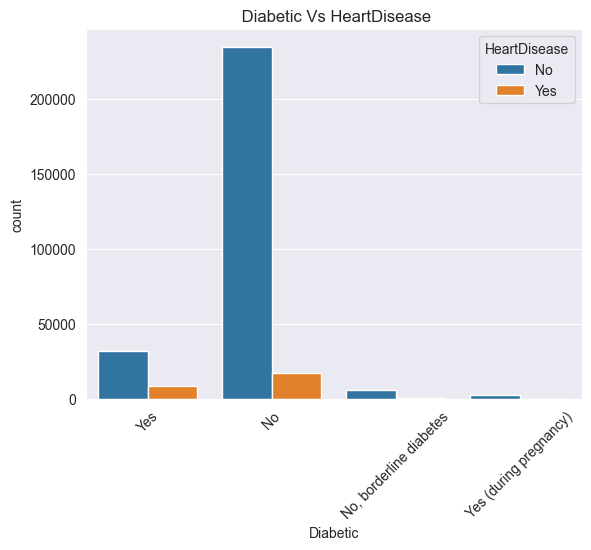

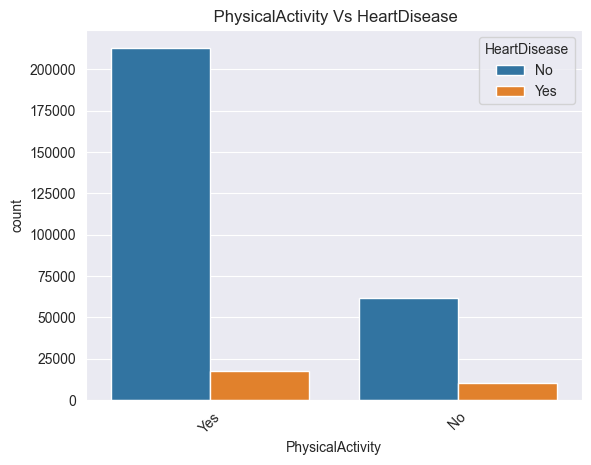

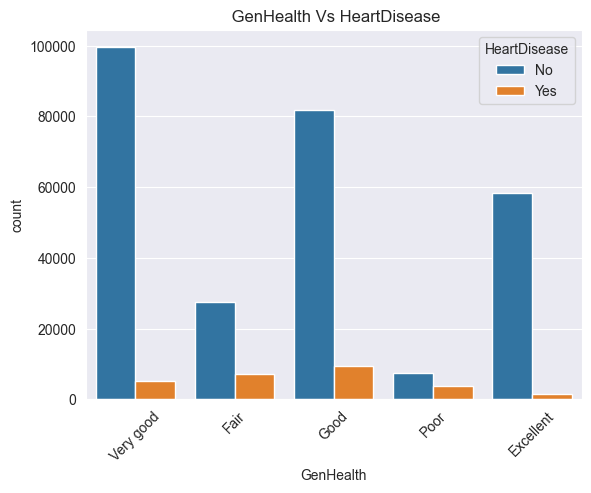

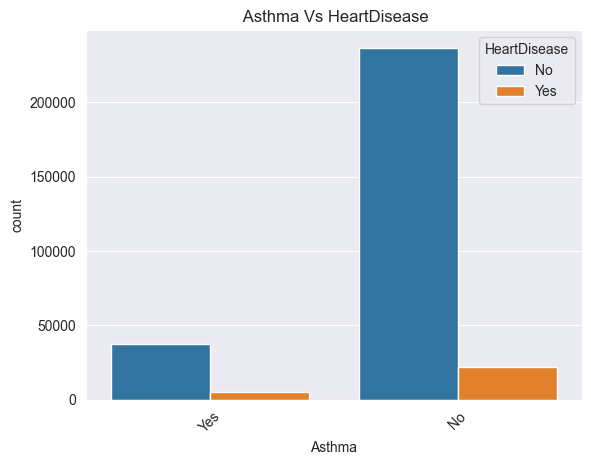

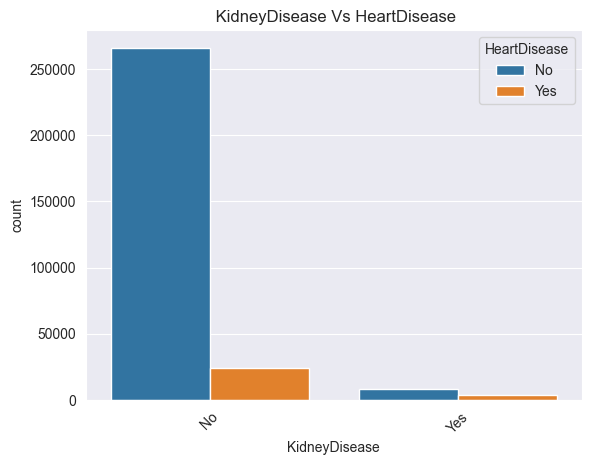

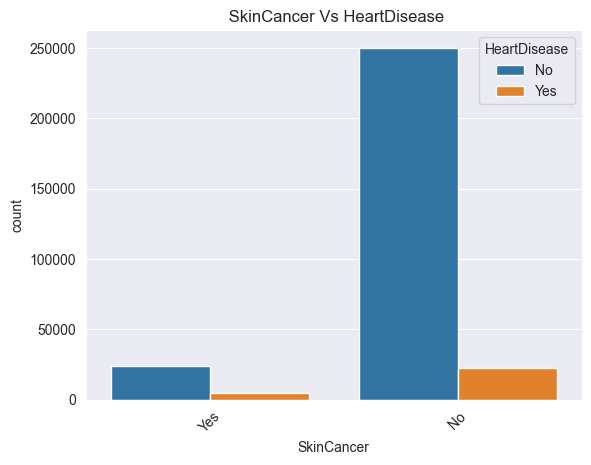

In [21]:
# catergorical columns

for i in range(len(categorical_features)):

  sns.countplot(x = categorical_features[i], data= df, hue='HeartDisease')
  plt.xticks(rotation=45)
  plt.title(f" {categorical_features[i]} Vs HeartDisease")
  plt.show()
  print('\n')

We will transform the data and treat outliers after splitting the train test data to prevent data leakage

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [23]:
# # checking the distribution
# print("Original distribution : ", y.value_counts(normalize=True) * 100)
# print(" \n Training distribution : ", y_train.value_counts(normalize=True) * 100)
# print(" \n test distribution : ", y_test.value_counts(normalize=True) * 100)

# Now, we have splitted the data, so we will start transforming it

In [24]:
# first, to remove outliers and normalize the numerical columns, we will try quantile transformation
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

In [25]:
df[numerical_features].skew() # if the value is between -0.5 to 0.5 then it is normal data else skewed

BMI               1.297737
PhysicalHealth    2.501000
MentalHealth      2.237470
SleepTime         0.697224
dtype: float64

In [26]:
# # trying the log transformation for numerical column as it is still right skewed
# df_new = df.copy()

# for i in range(len(numerical_features)):
#   df_new[numerical_features[i]] = np.log1p(df_new[numerical_features[i]])
#   print(df_new[numerical_features[i]].skew())
#   print('\n')



# log transformation is also not able to bring the data to normalized form, now will try to remove the outlier first and then will try again

In [27]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease'].map({'Yes':1, 'No':0})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0, stratify=y)

In [29]:
# checking the distribution
print("Original distribution : ", y.value_counts(normalize=True) * 100)
print(" \n Training distribution : ", y_train.value_counts(normalize=True) * 100)
print(" \n test distribution : ", y_test.value_counts(normalize=True) * 100)

Original distribution :  HeartDisease
0    90.964712
1     9.035288
Name: proportion, dtype: float64
 
 Training distribution :  HeartDisease
0    90.964607
1     9.035393
Name: proportion, dtype: float64
 
 test distribution :  HeartDisease
0    90.965133
1     9.034867
Name: proportion, dtype: float64


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from feature_engine.outliers import Winsorizer

In [31]:
# Get the actual numerical and categorical column names from X_train
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()
categorical_cols = X_train.select_dtypes(exclude='number').columns.tolist()


--------------------- LOGISTIC REGRESSION -------------------------

In [37]:
# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

# Define the full pipeline including preprocessing and the model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0, n_jobs=-1))
])

In [38]:
# Using stratifiedkfold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [39]:
scores = cross_val_score(lr_pipeline, X_train, y_train, cv=skf, scoring='roc_auc')

C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed i

In [40]:
scores

array([0.834395  , 0.83417201, 0.83526983, 0.83734075, 0.84010728])

In [41]:
lr_pipeline.fit(X_train, y_train)

C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [42]:
y_pred = lr_pipeline.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     54892
           1       0.23      0.78      0.35      5452

    accuracy                           0.74     60344
   macro avg       0.60      0.76      0.60     60344
weighted avg       0.90      0.74      0.80     60344



------------- DECISION TREE CLASSIFIER --------------------

In [44]:
# For Decision Tree Classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

# Define the full pipeline including preprocessing and the model
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

In [ ]:
tree_scores = cross_val_score(tree_pipeline, X_train, y_train, cv=skf, scoring='roc_auc')

In [ ]:
tree_scores

array([0.57724203, 0.57568446, 0.56819428, 0.57429913, 0.5785623 ])

In [45]:
tree_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [49]:
y_pred_tree = tree_pipeline.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     54892
           1       0.22      0.23      0.23      5452

    accuracy                           0.86     60344
   macro avg       0.57      0.58      0.57     60344
weighted avg       0.86      0.86      0.86     60344



--------------------------- K - Nearest Neighbor Classifier ---------------------

In [46]:
# KNN Classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

knn_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])


In [ ]:
print(cross_val_score(knn_pipeline, X_train, y_train, cv=skf, scoring='roc_auc'))

[0.69324958 0.69542521 0.69715241 0.69979869 0.70413117]


In [47]:
knn_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [53]:
y_pred_knn = knn_pipeline.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.98      0.94     54892
           1       0.27      0.09      0.14      5452

    accuracy                           0.90     60344
   macro avg       0.59      0.53      0.54     60344
weighted avg       0.86      0.90      0.87     60344



----------------------- Gaussian Naive Bayes Classifier ----------------------------

In [48]:
# GNB Classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

GNB_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [ ]:
print(cross_val_score(GNB_pipeline, X_train, y_train, cv=skf, scoring='roc_auc'))

[0.80157349 0.80317207 0.80266319 0.80267177 0.80515649]


In [49]:
GNB_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [57]:
y_pred_GNB = GNB_pipeline.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred_GNB))

              precision    recall  f1-score   support

           0       0.97      0.70      0.82     54892
           1       0.20      0.76      0.32      5452

    accuracy                           0.71     60344
   macro avg       0.59      0.73      0.57     60344
weighted avg       0.90      0.71      0.77     60344



--------------------- Random Forest Classifier  ---------------------------

In [50]:
# RF Classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

RF_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0, max_depth=5, n_jobs=-50))
])


In [ ]:
print(cross_val_score(RF_pipeline, X_train, y_train, cv=skf, scoring='roc_auc'))

[0.77419223 0.7767876  0.77781719 0.78150832 0.78203364]


In [51]:
RF_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [34]:
y_pred_RF = RF_pipeline.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     54892
           1       0.23      0.68      0.34      5452

    accuracy                           0.76     60344
   macro avg       0.59      0.73      0.60     60344
weighted avg       0.89      0.76      0.81     60344



--------------------------- XGBoost Classifier -------------------------------

In [52]:
# XGB Classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('capping', Winsorizer(capping_method='iqr', tail='both', fold=1.5), numerical_cols),
        ('num', QuantileTransformer(output_distribution="uniform"), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Pass through any columns not explicitly transformed
)

XGB_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(class_weight='balanced', random_state=0,))
])


In [ ]:
print(cross_val_score(XGB_pipeline, X_train, y_train, cv=skf, scoring='roc_auc'))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:13:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:14:20] WARNING: /workspace/src/learner

[0.82829063 0.82705032 0.82915728 0.83269434 0.83650755]


In [53]:
XGB_pipeline.fit(X_train, y_train)

C:\Users\HP\Desktop\ML\Assignment_2\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:59:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('capping', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [65]:
y_pred_XGB = XGB_pipeline.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54892
           1       0.49      0.10      0.17      5452

    accuracy                           0.91     60344
   macro avg       0.70      0.55      0.56     60344
weighted avg       0.88      0.91      0.88     60344



In [67]:
from sklearn.metrics import roc_auc_score

In [68]:
roc_auc_scores = {
    'Logistic Regression': roc_auc_score(y_test, y_pred),
    'Decision Tree': roc_auc_score(y_test, y_pred_tree),
    'KNN': roc_auc_score(y_test, y_pred_knn),
    'Gaussian Naive Bayes': roc_auc_score(y_test, y_pred_GNB),
    'Random Forest': roc_auc_score(y_test, y_pred_RF),
    'XGBoost': roc_auc_score(y_test, y_pred_XGB) }

In [ ]:
evalutaion_metrics = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['ROC_AUC_Score'])

In [ ]:
evalutaion_metrics.sort_values(by='ROC_AUC_Score', ascending=False)

,ROC_AUC_Score
Logistic Regression,0.759003
Gaussian Naive Bayes,0.732839
Decision Tree,0.577136
KNN,0.556117
XGBoost,0.546155
Random Forest,0.542371


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred):
    # Extract metrics for the positive class (class 1)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return precision, recall, f1


metrics_data = {}

# Logistic Regression
precision_lr, recall_lr, f1_lr = get_metrics(y_test, y_pred)
metrics_data['Logistic Regression'] = {'Precision (Class 1)': precision_lr, 'Recall (Class 1)': recall_lr, 'F1-Score (Class 1)': f1_lr, 'ROC AUC Score': roc_auc_scores['Logistic Regression']}

# Decision Tree
precision_tree, recall_tree, f1_tree = get_metrics(y_test, y_pred_tree)
metrics_data['Decision Tree'] = {'Precision (Class 1)': precision_tree, 'Recall (Class 1)': recall_tree, 'F1-Score (Class 1)': f1_tree, 'ROC AUC Score': roc_auc_scores['Decision Tree']}

# KNN
precision_knn, recall_knn, f1_knn = get_metrics(y_test, y_pred_knn)
metrics_data['KNN'] = {'Precision (Class 1)': precision_knn, 'Recall (Class 1)': recall_knn, 'F1-Score (Class 1)': f1_knn, 'ROC AUC Score': roc_auc_scores['KNN']}

# Gaussian Naive Bayes
precision_gnb, recall_gnb, f1_gnb = get_metrics(y_test, y_pred_GNB)
metrics_data['Gaussian Naive Bayes'] = {'Precision (Class 1)': precision_gnb, 'Recall (Class 1)': recall_gnb, 'F1-Score (Class 1)': f1_gnb, 'ROC AUC Score': roc_auc_scores['Gaussian Naive Bayes']}

# Random Forest
precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_pred_RF)
metrics_data['Random Forest'] = {'Precision (Class 1)': precision_rf, 'Recall (Class 1)': recall_rf, 'F1-Score (Class 1)': f1_rf, 'ROC AUC Score': roc_auc_scores['Random Forest']}

# XGBoost
precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_pred_XGB)
metrics_data['XGBoost'] = {'Precision (Class 1)': precision_xgb, 'Recall (Class 1)': recall_xgb, 'F1-Score (Class 1)': f1_xgb, 'ROC AUC Score': roc_auc_scores['XGBoost']}

comparison_df = pd.DataFrame.from_dict(metrics_data, orient='index')
comparison_df.index.name = 'Model'
display(comparison_df)

,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),ROC AUC Score
Model,,,,
Logistic Regression,0.229087,0.778063,0.353957,0.759003
Decision Tree,0.228628,0.232025,0.230314,0.577136
KNN,0.272966,0.152605,0.195765,0.556117
Gaussian Naive Bayes,0.200314,0.771643,0.318062,0.732839
Random Forest,0.289436,0.112069,0.161576,0.542371
XGBoost,0.503156,0.102348,0.170096,0.546155


# Dumping all the models in pkl

In [54]:
import joblib

In [55]:
joblib.dump(lr_pipeline, 'lr_pipeline3.pkl')
joblib.dump(tree_pipeline, 'tree_pipeline3.pkl')
joblib.dump(knn_pipeline, 'knn_pipeline3.pkl')
joblib.dump(GNB_pipeline, 'GNB_pipeline3.pkl')
joblib.dump(RF_pipeline, 'RF_pipeline3.pkl')
joblib.dump(XGB_pipeline, 'XGB_pipeline3.pkl')

['XGB_pipeline3.pkl']

In [87]:
def get_preprocessed_data(pipeline, X, numerical_cols, categorical_cols):
    preprocessor = pipeline.named_steps["preprocessor"]

    X_processed = preprocessor.transform(X)

    # categorical names
    ohe = preprocessor.named_transformers_['cat']
    cat_names = ohe.get_feature_names_out(categorical_cols)

    # passthrough
    remaining_cols = [c for c in X.columns if c not in numerical_cols + categorical_cols]

    all_columns = list(numerical_cols) + list(cat_names) + remaining_cols
    print("X_processed shape : ", X_processed.shape)
    print("all columns shape : ", len(all_columns))
    return pd.DataFrame(X_processed, columns=all_columns)


In [ ]:
preprocessed_data = get_preprocessed_data(lr_pipeline, X, numerical_cols, categorical_cols)